In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import io
import urllib.request


from konlpy.tag import Okt
from tqdm import tqdm
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

## 네이버영화, 강사님 영화 리뷰 데이터 합친 파일 불러오기

In [3]:
# 수집한 데이터, 강사님 데이터 합친 파일 불러오기 - label : 0 -> 부정, 1 -> 긍정
df = pd.read_csv('review_data.csv', low_memory=False, encoding = 'UTF-8')
df.head()

,sentence,label
0,믿고 보는 마블 스토리 ㅋ,1
1,액션을 기대하고 봤다면 반대. 연기를 기대하고 봤다면 끝까지,0
2,사전 정보 없이 봤는데 러닝타임 내내 시간 가는 줄 모르게 봤습니다,1
3,미쳤다.. 내 시간 순삭 당하고 옴,1
4,이 영화는 한마디로 해리 포터+제다이(스타워즈)+호빗+스타트렉 4가지의 영화를 합...,1


In [4]:
print(df.isnull().sum())

sentence    32
label        0
dtype: int64


In [5]:
df = df.dropna(how = 'any') 

In [6]:
df_review = df['sentence']
df_review

0                                            믿고 보는 마블 스토리 ㅋ
1                         액션을 기대하고 봤다면 반대. 연기를 기대하고 봤다면 끝까지
2                     사전 정보 없이 봤는데 러닝타임 내내 시간 가는 줄 모르게 봤습니다
3                                       미쳤다.. 내 시간 순삭 당하고 옴
4         이 영화는 한마디로 해리 포터+제다이(스타워즈)+호빗+스타트렉  4가지의 영화를 합...
                                ...                        
209360            오랜만에 평점 로긴했네ㅋㅋ 킹왕짱 쌈뽕한 영화를 만났습니다 강렬하게 육쾌함
209361         의지 박약들이나 하는거다 탈영은 일단 주인공 김대희 닮았고 이등병 찐따 OOOO
209362                   그림도 좋고 완성도도 높았지만... 보는 내내 불안하게 만든다
209363       절대 봐서는 안 될 영화.. 재미도 없고 기분만 잡치고.. 한 세트장에서 다 해먹네
209364                                           마무리는 또 왜이래
Name: sentence, Length: 209333, dtype: object

## 전처리

In [7]:
#영어 소문자로 모두 변환
df_review = df_review.str.lower()

In [8]:
df_review[100:140]

100                                지대 잘 만들었다 네이비 실 위엄 지림
101                                  쿠키 2개. 2편 존비 탑니다...
102    오래간만에 조폭영화 재밌게 봤네... 조폭영화 미화도 안 하고 의리 없는 게 딱 현...
103                                        영화가 아닌 다큐멘터리 
104                                    포피가 피포파 포피파파피포파ㅠㅠ
105                     생각보다는 재밌었다. 주인공이나 빌런이나 서사 다 좋았음.
106                              빨리 d.c에서 제임스 완 데려와요..ㅠㅠ
107                              진짜 꼭 보길,, 역시 최민식 배우님 최고
108    분위기가 묘하게 독특하고 한국 영화가 아닌 것 같은 느낌을 받았는데 감독이 프랑스인...
109    배우 연기가 아깝게 느껴지는 구멍 술술 설정과 어지러운 cg 화면의 대 환장 콜라보...
110    역시 믿고 보는 갓 연우진! 몰입도 높고 쫀쫀한 스토리 때문에 재미있게 봤습니다.....
111                                           사는 게 지옥이다.
112    올가 배우를 이렇게 보게 되어서 너무 좋았어요! 앞으로 더 많은 작품 볼 수 있으면...
113    [스포 있음] 방금 보고 나왔는데요…! 어… 엄청난 범죄 영화같이 홍보 해놓고 결말...
114                      열 일하시는 김동완 배우님에 눈물이 앞을 가립니다….ㅠㅠ
115                                     아... 이거뭔가요....ㅠㅠ
116                                     21세기에 맞게 뒤집어버리다!
117                     어색할 줄 알

In [9]:
#반복되는 문자 제거하기

df_review = df_review.str.replace("ㅋ","") # ㅋㅋㅋ제거
df_review = df_review.str.replace("ㅜ","") # ㅜㅜㅜ제거
df_review = df_review.str.replace("ㅠ","") # ㅠㅠㅠ제거
df_review = df_review.str.replace("ㅎ","") # ㅎㅎㅎ제거
df_review = df_review.str.replace("ㅇ","") # ㅇㅇ제거
df_review = df_review.str.replace("ㄷ","") # ㄷㄷ제거
df_review = df_review.str.replace("ㄱ","") # ㄱㄱ제거
df_review = df_review.str.replace("-","") # --제거
df_review = df_review.str.replace("_","") # __제거
df_review = df_review.str.replace("ㅡ","") # ㅡㅡ제거

#
df_review = df_review.str.replace("ㅉ","")
df_review = df_review.str.replace("ㅆㅈ","")
df_review = df_review.str.replace("ㅏ","")
df_review = df_review.str.replace("ㅡ","")

In [10]:
#단어 변환해주기
df_review = df_review.str.replace("ㄱㅊ","괜찮")

# 추가 단어 #
#줄임말 변경
df_review = df_review.str.replace("ㅈㄹ","지랄")
df_review = df_review.str.replace("ㅈㅁ","정말")
df_review = df_review.str.replace("ㅇㅈ","인정")
df_review = df_review.str.replace("ㄹㅇ","정말")
df_review = df_review.str.replace("ㅈㅅ","죄송")
df_review = df_review.str.replace("좋ㅈ었습니다","좋았습니다")
df_review = df_review.str.replace("ㅈㄴ","존나")


#영어표현 변경
df_review = df_review.str.replace("cg","씨지")
df_review = df_review.str.replace("ost","오에스티")
df_review = df_review.str.replace("sf","공상과학")
df_review = df_review.str.replace("tv","텔레비전")
df_review = df_review.str.replace("sns","소셜미디어")
df_review = df_review.str.replace("good","좋다")
df_review = df_review.str.replace("best","좋다")

In [11]:
#정규표현식 
df_review = df_review.str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 한글과 공백을 제외하고 모두 제거
df_review = df_review.str.replace('^ +', " ") #공백은 empty값으로 변경
#df_review.drop_duplicates(subset = ['content'], inplace=True) # document 열에서 중복인 내용이 있다면 중복 제거
df_review.replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
df_review = df_review.dropna(how='any') # Null 값 제거
print('전처리 후 테스트용 샘플의 개수 :',len(df_review))

C:\Users\user\AppData\Local\Temp/ipykernel_9096/4275888759.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df_review = df_review.str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 한글과 공백을 제외하고 모두 제거
C:\Users\user\AppData\Local\Temp/ipykernel_9096/4275888759.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  df_review = df_review.str.replace('^ +', "") #공백은 empty값으로 변경


전처리 후 테스트용 샘플의 개수 : 207580


In [12]:
df_review[:30]

0                                         믿고 보는 마블 스토리 
1                      액션을 기대하고 봤다면 반대 연기를 기대하고 봤다면 끝까지
2                 사전 정보 없이 봤는데 러닝타임 내내 시간 가는 줄 모르게 봤습니다
3                                     미쳤다 내 시간 순삭 당하고 옴
4     이 영화는 한마디로 해리 포터제다이스타워즈호빗스타트렉  가지의 영화를 합친 것보다 ...
5                                       자레드 레토 연기 너무 잘함
6     느닷없는 개연성과 범죄 스릴러에 억지로 로맨스 장르를 부합하는 어이없는 시도 평소 ...
7                  평점 점이라서 꺼렸는데 누가 추천해줘서 봤는데 진짜 재미지게 봄 
8     베놈 보다는 훨씬 잘 만들었다 오에스티는 다크 아네트 느낌이 강하게 느껴진다 표절했...
9     마블 영화를 전체적으로 봐왔던 사람으로서 이 영화는 단순히 생각 없이 보길 추천함 ...
10                                        올해 최고의 코미디 영화
11    경상도 토박인데 사투리 어색해서 집중 안 됐음 어색한 사투리웅얼웅얼 대사 쳐서 뭔 ...
12    큰 기대를 안 하고 관람해서 그런지 아주 재미있지도 않고 아주 재미없지도 않았던 그...
13                         생존하게 해준 고든이랑 샤샤만 살았어도 좋았을 듯 
14                                         잔잔하니 감동적이네요 
15                                       진짜 영화가 미제다 미제 
16                                  진짜 재미없고 말소리도 잘 안들리고
17                                         연기들은 

In [13]:
#전처리 데이터 다시 넣어주기
df['sentence'] = df_review

In [14]:
df

,sentence,label
0,믿고 보는 마블 스토리,1
1,액션을 기대하고 봤다면 반대 연기를 기대하고 봤다면 끝까지,0
2,사전 정보 없이 봤는데 러닝타임 내내 시간 가는 줄 모르게 봤습니다,1
3,미쳤다 내 시간 순삭 당하고 옴,1
4,이 영화는 한마디로 해리 포터제다이스타워즈호빗스타트렉 가지의 영화를 합친 것보다 ...,1
...,...,...
209360,오랜만에 평점 로긴했네 킹왕짱 쌈뽕한 영화를 만났습니다 강렬하게 육쾌함,1
209361,의지 박약들이나 하는거다 탈영은 일단 주인공 김대희 닮았고 이등병 찐따,0
209362,그림도 좋고 완성도도 높았지만 보는 내내 불안하게 만든다,0
209363,절대 봐서는 안 될 영화 재미도 없고 기분만 잡치고 한 세트장에서 다 해먹네,0


## py-hanspell 적용하기
naver 띄어쓰기, 맞춤법 검사기

In [ ]:
#print(df.isnull().sum())

In [ ]:
#df = df.dropna(how = 'any') # Null 값이 한개라도 존재하는 행 제거

In [ ]:
#print(df.isnull().sum())

In [ ]:
#hanspell은 500자까지만 분석해주기때문에
#500자 이상의 값은 넘어가게 함수 만들어줌

#from hanspell import spell_checker

#new_sent = []
#def review_sent(text):
    #for i in range(len(text)):
        #spelled_sent = spell_checker.check(text[i])
        #hanspell_sent = spelled_sent.checked
        #sent = hanspell_sent
        #new_sent.append(sent)

In [ ]:
#review_sent(df['sentence'])

In [ ]:
#df['sentence'] = new_sent

In [ ]:
#df

In [ ]:
#완성된 데이터파일 csv파일로 저장하기
#df.to_csv('review_preprocessing_ver2.csv',index=False)

## 불용어 지정

In [ ]:
#불용어지정하기 ->소연

#불용어지정
#stopwords = ['을','의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다','요','이다','-']

#형태소분석기 정하기

In [ ]:
#df_s = df['sentence'] 

In [ ]:
#df_s = [i for i in df_s if i not in stopwords]

In [ ]:
#df_s

## 형태소분석기_konlpy_okt사용

In [15]:
from konlpy.tag import Kkma, Komoran, Okt
import io
from konlpy.utils import pprint
import urllib.request 
import time


#mec = Mecab()
okt = Okt()
kkm = Kkma()
kom = Komoran()

In [16]:
import konlpy
print(konlpy.__version__)

0.6.0


In [17]:
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize

In [18]:
df.isnull().sum()

sentence    1753
label          0
dtype: int64

In [19]:
df = df.dropna(how = 'any') # Null 값이 한개라도 존재하는 행 제거

In [20]:
df.isnull().sum()

sentence    0
label       0
dtype: int64

In [21]:
df.reset_index(drop = True, inplace = True)

In [22]:
df

,sentence,label
0,믿고 보는 마블 스토리,1
1,액션을 기대하고 봤다면 반대 연기를 기대하고 봤다면 끝까지,0
2,사전 정보 없이 봤는데 러닝타임 내내 시간 가는 줄 모르게 봤습니다,1
3,미쳤다 내 시간 순삭 당하고 옴,1
4,이 영화는 한마디로 해리 포터제다이스타워즈호빗스타트렉 가지의 영화를 합친 것보다 ...,1
...,...,...
207575,오랜만에 평점 로긴했네 킹왕짱 쌈뽕한 영화를 만났습니다 강렬하게 육쾌함,1
207576,의지 박약들이나 하는거다 탈영은 일단 주인공 김대희 닮았고 이등병 찐따,0
207577,그림도 좋고 완성도도 높았지만 보는 내내 불안하게 만든다,0
207578,절대 봐서는 안 될 영화 재미도 없고 기분만 잡치고 한 세트장에서 다 해먹네,0


In [23]:
review_tag = []

for sentence in tqdm(df['sentence']):
    tokenized_sentence = okt.pos(sentence, stem = True) # 토큰화
    review_tag.append(tokenized_sentence)

100%|█████████████████████████████████████████████████████████████████████████| 207580/207580 [07:59<00:00, 432.84it/s]


In [24]:
review_tag[:100] #Noun, Verb, Adjective

[[('믿다', 'Verb'), ('보다', 'Verb'), ('마블', 'Noun'), ('스토리', 'Noun')],
 [('액션', 'Noun'),
  ('을', 'Josa'),
  ('기대하다', 'Adjective'),
  ('보다', 'Verb'),
  ('반대', 'Noun'),
  ('연기', 'Noun'),
  ('를', 'Josa'),
  ('기대하다', 'Adjective'),
  ('보다', 'Verb'),
  ('끝', 'Noun'),
  ('까지', 'Josa')],
 [('사전', 'Noun'),
  ('정보', 'Noun'),
  ('없이', 'Adverb'),
  ('보다', 'Verb'),
  ('러닝', 'Noun'),
  ('타임', 'Noun'),
  ('내내', 'Noun'),
  ('시간', 'Noun'),
  ('가다', 'Verb'),
  ('줄', 'Noun'),
  ('모르다', 'Verb'),
  ('보다', 'Verb')],
 [('미치다', 'Adjective'),
  ('내', 'Noun'),
  ('시간', 'Noun'),
  ('순삭', 'Noun'),
  ('당하다', 'Adjective'),
  ('옴', 'Noun')],
 [('이', 'Noun'),
  ('영화', 'Noun'),
  ('는', 'Josa'),
  ('한마디', 'Noun'),
  ('로', 'Josa'),
  ('해리', 'Noun'),
  ('포터', 'Noun'),
  ('제다이', 'Noun'),
  ('스타워즈', 'Noun'),
  ('호빗', 'Noun'),
  ('스타트렉', 'Noun'),
  ('가지', 'Noun'),
  ('의', 'Josa'),
  ('영화', 'Noun'),
  ('를', 'Josa'),
  ('합치다', 'Verb'),
  ('것', 'Noun'),
  ('보다', 'Josa'),
  ('배', 'Noun'),
  ('나', 'Josa'),
  ('재미있다', 'Adjective')],

In [25]:
df['tagging'] = review_tag

C:\Users\user\AppData\Local\Temp/ipykernel_9096/3230844241.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['tagging'] = review_tag


In [26]:
df.head()

,sentence,label,tagging
0,믿고 보는 마블 스토리,1,"[(믿다, Verb), (보다, Verb), (마블, Noun), (스토리, Noun)]"
1,액션을 기대하고 봤다면 반대 연기를 기대하고 봤다면 끝까지,0,"[(액션, Noun), (을, Josa), (기대하다, Adjective), (보다..."
2,사전 정보 없이 봤는데 러닝타임 내내 시간 가는 줄 모르게 봤습니다,1,"[(사전, Noun), (정보, Noun), (없이, Adverb), (보다, Ve..."
3,미쳤다 내 시간 순삭 당하고 옴,1,"[(미치다, Adjective), (내, Noun), (시간, Noun), (순삭,..."
4,이 영화는 한마디로 해리 포터제다이스타워즈호빗스타트렉 가지의 영화를 합친 것보다 ...,1,"[(이, Noun), (영화, Noun), (는, Josa), (한마디, Noun)..."


In [27]:
df.tail()

,sentence,label,tagging
207575,오랜만에 평점 로긴했네 킹왕짱 쌈뽕한 영화를 만났습니다 강렬하게 육쾌함,1,"[(오랜, Modifier), (만, Noun), (에, Josa), (평점, No..."
207576,의지 박약들이나 하는거다 탈영은 일단 주인공 김대희 닮았고 이등병 찐따,0,"[(의지, Noun), (박약, Noun), (들, Suffix), (이나, Jos..."
207577,그림도 좋고 완성도도 높았지만 보는 내내 불안하게 만든다,0,"[(그림, Noun), (도, Josa), (좋다, Adjective), (완성, ..."
207578,절대 봐서는 안 될 영화 재미도 없고 기분만 잡치고 한 세트장에서 다 해먹네,0,"[(절대, Noun), (보다, Verb), (서다, Verb), (안, Noun)..."
207579,마무리는 또 왜이래,0,"[(마무리, Noun), (는, Josa), (또, Noun), (왜, Noun),..."


In [28]:
print(df.isnull().sum())

sentence    0
label       0
tagging     0
dtype: int64


In [29]:
tag = df["tagging"]

In [30]:
# 5. 명사 혹은 형용사인 품사만 선별해 리스트에 담기
words_list = []
for sentence1 in review_tag:
    for word, tag in sentence1:
        if tag in ['Noun','Adjective','Verb']:
            words_list.append(word)

In [31]:
words_list

['믿다',
 '보다',
 '마블',
 '스토리',
 '액션',
 '기대하다',
 '보다',
 '반대',
 '연기',
 '기대하다',
 '보다',
 '끝',
 '사전',
 '정보',
 '보다',
 '러닝',
 '타임',
 '내내',
 '시간',
 '가다',
 '줄',
 '모르다',
 '보다',
 '미치다',
 '내',
 '시간',
 '순삭',
 '당하다',
 '옴',
 '이',
 '영화',
 '한마디',
 '해리',
 '포터',
 '제다이',
 '스타워즈',
 '호빗',
 '스타트렉',
 '가지',
 '영화',
 '합치다',
 '것',
 '배',
 '재미있다',
 '자레드',
 '레토',
 '연기',
 '하다',
 '느닷없다',
 '개연',
 '성과',
 '범죄',
 '스릴러',
 '억지로',
 '로맨스',
 '장르',
 '부합',
 '하다',
 '어이없다',
 '시도',
 '평소',
 '영화',
 '보다',
 '눈',
 '높다',
 '편이',
 '아니다',
 '소재',
 '아깝다',
 '뿐',
 '전개',
 '별로',
 '이다',
 '평점',
 '점',
 '꺼리다',
 '누가',
 '추천',
 '해주다',
 '보다',
 '진짜',
 '재미',
 '지게',
 '봄',
 '베놈',
 '자다',
 '만들다',
 '에스티',
 '다크',
 '네트',
 '느낌',
 '강하다',
 '느껴지다',
 '표절',
 '하다',
 '이',
 '정도',
 '비슷하다',
 '들리다',
 '마블',
 '영화',
 '전체',
 '보다',
 '오다',
 '사람',
 '이',
 '영화',
 '단순하다',
 '생각',
 '보다',
 '추천',
 '함',
 '설정',
 '자체',
 '식상하다',
 '능력',
 '신',
 '나',
 '투신',
 '같다',
 '경우',
 '나쁘다',
 '않다',
 '일단',
 '스토리',
 '자체',
 '기대',
 '하다',
 '볼',
 '필요',
 '없다',
 '생각',
 '함',
 '정말',
 '내',
 '보다',
 '오다',
 '영화',
 '중',
 '가장

In [101]:
review_new = []

for sentence in tqdm(df['sentence'][:50000]):
    tokenized_sentence = okt.pos(sentence, stem = True) # 토큰화
    words_list_sentence = [word for word, tag in tokenized_sentence if tag in ['Noun','Adjective','Verb']] 
    review_new.append(words_list_sentence)

100%|███████████████████████████████████████████████████████████████████████████| 50000/50000 [02:17<00:00, 363.12it/s]


In [102]:
for sentence in tqdm(df['sentence'][50000:100000]):
    tokenized_sentence = okt.pos(sentence, stem = True) # 토큰화
    words_list_sentence = [word for word, tag in tokenized_sentence if tag in ['Noun','Adjective','Verb']]
    review_new.append(words_list_sentence)

100%|███████████████████████████████████████████████████████████████████████████| 50000/50000 [02:10<00:00, 384.59it/s]


In [103]:
for sentence in tqdm(df['sentence'][100000:150000]):
    tokenized_sentence = okt.pos(sentence, stem = True) # 토큰화
    words_list_sentence = [word for word, tag in tokenized_sentence if tag in ['Noun','Adjective','Verb']]
    review_new.append(words_list_sentence)

100%|███████████████████████████████████████████████████████████████████████████| 50000/50000 [02:15<00:00, 368.71it/s]


In [104]:
for sentence in tqdm(df['sentence'][150000:200000]):
    tokenized_sentence = okt.pos(sentence, stem = True) # 토큰화
    words_list_sentence = [word for word, tag in tokenized_sentence if tag in ['Noun','Adjective','Verb']]
    review_new.append(words_list_sentence)

100%|███████████████████████████████████████████████████████████████████████████| 50000/50000 [02:29<00:00, 335.44it/s]


In [105]:
for sentence in tqdm(df['sentence'][200000:207580]):
    tokenized_sentence = okt.pos(sentence, stem = True) # 토큰화
    words_list_sentence = [word for word, tag in tokenized_sentence if tag in ['Noun','Adjective','Verb']]
    review_new.append(words_list_sentence)

100%|█████████████████████████████████████████████████████████████████████████████| 7580/7580 [00:22<00:00, 340.17it/s]


In [107]:
len(review_new)

207580

In [108]:
review_new

[['믿다', '보다', '마블', '스토리'],
 ['액션', '기대하다', '보다', '반대', '연기', '기대하다', '보다', '끝'],
 ['사전', '정보', '보다', '러닝', '타임', '내내', '시간', '가다', '줄', '모르다', '보다'],
 ['미치다', '내', '시간', '순삭', '당하다', '옴'],
 ['이',
  '영화',
  '한마디',
  '해리',
  '포터',
  '제다이',
  '스타워즈',
  '호빗',
  '스타트렉',
  '가지',
  '영화',
  '합치다',
  '것',
  '배',
  '재미있다'],
 ['자레드', '레토', '연기', '하다'],
 ['느닷없다',
  '개연',
  '성과',
  '범죄',
  '스릴러',
  '억지로',
  '로맨스',
  '장르',
  '부합',
  '하다',
  '어이없다',
  '시도',
  '평소',
  '영화',
  '보다',
  '눈',
  '높다',
  '편이',
  '아니다',
  '소재',
  '아깝다',
  '뿐',
  '전개',
  '별로',
  '이다'],
 ['평점', '점', '꺼리다', '누가', '추천', '해주다', '보다', '진짜', '재미', '지게', '봄'],
 ['베놈',
  '자다',
  '만들다',
  '에스티',
  '다크',
  '네트',
  '느낌',
  '강하다',
  '느껴지다',
  '표절',
  '하다',
  '이',
  '정도',
  '비슷하다',
  '들리다'],
 ['마블',
  '영화',
  '전체',
  '보다',
  '오다',
  '사람',
  '이',
  '영화',
  '단순하다',
  '생각',
  '보다',
  '추천',
  '함',
  '설정',
  '자체',
  '식상하다',
  '능력',
  '신',
  '나',
  '투신',
  '같다',
  '경우',
  '나쁘다',
  '않다',
  '일단',
  '스토리',
  '자체',
  '기대',
  '하다',
  '볼',
  '필요',
 

In [109]:
df['tag_list'] = review_new

C:\Users\user\AppData\Local\Temp/ipykernel_9096/2448005592.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['tag_list'] = review_new


In [110]:
df

,sentence,label,tagging,tag_list
0,믿고 보는 마블 스토리,1,"[(믿다, Verb), (보다, Verb), (마블, Noun), (스토리, Noun)]","[믿다, 보다, 마블, 스토리]"
1,액션을 기대하고 봤다면 반대 연기를 기대하고 봤다면 끝까지,0,"[(액션, Noun), (을, Josa), (기대하다, Adjective), (보다...","[액션, 기대하다, 보다, 반대, 연기, 기대하다, 보다, 끝]"
2,사전 정보 없이 봤는데 러닝타임 내내 시간 가는 줄 모르게 봤습니다,1,"[(사전, Noun), (정보, Noun), (없이, Adverb), (보다, Ve...","[사전, 정보, 보다, 러닝, 타임, 내내, 시간, 가다, 줄, 모르다, 보다]"
3,미쳤다 내 시간 순삭 당하고 옴,1,"[(미치다, Adjective), (내, Noun), (시간, Noun), (순삭,...","[미치다, 내, 시간, 순삭, 당하다, 옴]"
4,이 영화는 한마디로 해리 포터제다이스타워즈호빗스타트렉 가지의 영화를 합친 것보다 ...,1,"[(이, Noun), (영화, Noun), (는, Josa), (한마디, Noun)...","[이, 영화, 한마디, 해리, 포터, 제다이, 스타워즈, 호빗, 스타트렉, 가지, ..."
...,...,...,...,...
207575,오랜만에 평점 로긴했네 킹왕짱 쌈뽕한 영화를 만났습니다 강렬하게 육쾌함,1,"[(오랜, Modifier), (만, Noun), (에, Josa), (평점, No...","[만, 평점, 로, 기다, 하다, 킹왕짱, 쌈뽕, 영화, 만나다, 강렬하다, 쾌함]"
207576,의지 박약들이나 하는거다 탈영은 일단 주인공 김대희 닮았고 이등병 찐따,0,"[(의지, Noun), (박약, Noun), (들, Suffix), (이나, Jos...","[의지, 박약, 하다, 탈영, 일단, 주인공, 김대희, 닮다, 이등병, 찌다, 따다]"
207577,그림도 좋고 완성도도 높았지만 보는 내내 불안하게 만든다,0,"[(그림, Noun), (도, Josa), (좋다, Adjective), (완성, ...","[그림, 좋다, 완성, 도도, 높다, 보다, 내내, 불안하다, 만들다]"
207578,절대 봐서는 안 될 영화 재미도 없고 기분만 잡치고 한 세트장에서 다 해먹네,0,"[(절대, Noun), (보다, Verb), (서다, Verb), (안, Noun)...","[절대, 보다, 서다, 안, 되다, 영화, 재미, 없다, 기분, 잡, 하다, 세트,..."


In [111]:
from collections import Counter
counts = Counter(words_list)
print(counts.most_common(30))

[('영화', 71842), ('하다', 58943), ('보다', 54502), ('없다', 22042), ('좋다', 18291), ('있다', 18138), ('정말', 13228), ('재밌다', 13035), ('되다', 12863), ('이다', 12113), ('같다', 11994), ('진짜', 11837), ('아니다', 11057), ('않다', 10964), ('이', 10714), ('점', 10504), ('연기', 9922), ('것', 9383), ('만들다', 9195), ('나오다', 9095), ('평점', 8807), ('최고', 8438), ('스토리', 7792), ('생각', 7733), ('왜', 7146), ('감동', 6963), ('사람', 6923), ('드라마', 6776), ('보고', 6675), ('배우', 6508)]


### Train data, Test data split

In [3]:
df = pd.read_csv('movie_review_data.csv', encoding = 'UTF-8')
df

,sentence,label,tagging,tag_list
0,믿고 보는 마블 스토리,1,"[('믿다', 'Verb'), ('보다', 'Verb'), ('마블', 'Noun'...","['믿다', '보다', '마블', '스토리']"
1,액션을 기대하고 봤다면 반대 연기를 기대하고 봤다면 끝까지,0,"[('액션', 'Noun'), ('을', 'Josa'), ('기대하다', 'Adje...","['액션', '기대하다', '보다', '반대', '연기', '기대하다', '보다',..."
2,사전 정보 없이 봤는데 러닝타임 내내 시간 가는 줄 모르게 봤습니다,1,"[('사전', 'Noun'), ('정보', 'Noun'), ('없이', 'Adver...","['사전', '정보', '보다', '러닝', '타임', '내내', '시간', '가다..."
3,미쳤다 내 시간 순삭 당하고 옴,1,"[('미치다', 'Adjective'), ('내', 'Noun'), ('시간', '...","['미치다', '내', '시간', '순삭', '당하다', '옴']"
4,이 영화는 한마디로 해리 포터제다이스타워즈호빗스타트렉 가지의 영화를 합친 것보다 ...,1,"[('이', 'Noun'), ('영화', 'Noun'), ('는', 'Josa'),...","['이', '영화', '한마디', '해리', '포터', '제다이', '스타워즈', ..."
...,...,...,...,...
207575,오랜만에 평점 로긴했네 킹왕짱 쌈뽕한 영화를 만났습니다 강렬하게 육쾌함,1,"[('오랜', 'Modifier'), ('만', 'Noun'), ('에', 'Jos...","['만', '평점', '로', '기다', '하다', '킹왕짱', '쌈뽕', '영화'..."
207576,의지 박약들이나 하는거다 탈영은 일단 주인공 김대희 닮았고 이등병 찐따,0,"[('의지', 'Noun'), ('박약', 'Noun'), ('들', 'Suffix...","['의지', '박약', '하다', '탈영', '일단', '주인공', '김대희', '..."
207577,그림도 좋고 완성도도 높았지만 보는 내내 불안하게 만든다,0,"[('그림', 'Noun'), ('도', 'Josa'), ('좋다', 'Adject...","['그림', '좋다', '완성', '도도', '높다', '보다', '내내', '불안..."
207578,절대 봐서는 안 될 영화 재미도 없고 기분만 잡치고 한 세트장에서 다 해먹네,0,"[('절대', 'Noun'), ('보다', 'Verb'), ('서다', 'Verb'...","['절대', '보다', '서다', '안', '되다', '영화', '재미', '없다'..."


In [117]:
# 데이터 저장
df.to_csv('movie_review_data.csv', index = False)

In [4]:
train_data = df['tag_list']
test_data = df['label'].values

In [5]:
train_data.shape

(207580,)

In [6]:
test_data.shape

(207580,)

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(train_data, test_data, test_size = 0.2, random_state = 422)

In [8]:
print(f'X_train: {X_train.shape}, X_test: {X_test.shape}, Y_train: {Y_train.shape}, Y_test: {Y_test.shape}')

X_train: (166064,), X_test: (41516,), Y_train: (166064,), Y_test: (41516,)


### 단어의 길이 분포 확인

In [9]:
negative_words = np.hstack(df[df.label == 0]['tag_list'].values)
positive_words = np.hstack(df[df.label == 1]['tag_list'].values)

In [10]:
# 부정리뷰에 많이 나오는 단어 (100개)
from collections import Counter
negative_word_count = Counter(negative_words)
print(negative_word_count.most_common(100))

[("['재미없다']", 310), ('[]', 290), ("['별로']", 233), ("['쓰레기']", 158), ("['지루하다']", 108), ("['텔레비전', '기세', '아깝다']", 91), ("['좋다']", 87), ("['최악']", 86), ("['재미', '없다']", 82), ("['별루']", 68), ("['뭐']", 62), ("['점도', '아깝다']", 60), ("['진짜', '재미없다']", 59), ("['점']", 55), ("['시간', '아깝다']", 49), ("['것', '영화']", 45), ("['하다', '없다']", 44), ("['쓰레기', '영화']", 43), ("['보다']", 40), ("['이건', '뭐']", 38), ("['이', '영화']", 37), ("['영화']", 37), ("['유치하다']", 36), ("['지루함']", 36), ("['정말', '재미없다']", 33), ("['재밌다']", 32), ("['이건', '아니다']", 32), ("['그렇다']", 31), ("['음']", 30), ("['잼', '없다']", 28), ("['점', '없다']", 26), ("['실망']", 26), ("['평점', '높다']", 26), ("['최악', '영화']", 25), ("['점', '되다']", 25), ("['돈', '아깝다']", 24), ("['컴퓨터', '기세', '아깝다']", 24), ("['그냥']", 24), ("['드럽다', '재미없다']", 23), ("['이', '뭐']", 23), ("['그냥', '그렇다']", 22), ("['굿']", 22), ("['물체', '움직이다', '어떻다', '진행', '되다', '빠르기']", 22), ("['글쎄']", 22), ("['지루']", 22), ("['더럽다', '재미없다']", 22), ("['종합', '평점', '점', '드리다']", 22), ("['헐다']", 21), ("['원주율']"

In [11]:
# 긍정리뷰에 많이 나오는 단어 (100개)
positive_word_count = Counter(positive_words)
print(positive_word_count.most_common(100))

[("['재밌다']", 653), ("['좋다']", 535), ("['재미있다']", 331), ("['굿']", 305), ("['최고']", 248), ("['짱']", 115), ("['재다']", 113), ('[]', 110), ("['감동']", 108), ("['굳다']", 98), ("['재밌다', '보다']", 97), ("['괜찮다']", 72), ("['좋다', '영화']", 66), ("['대박']", 65), ("['최고', '영화']", 61), ("['재미있다', '보다']", 59), ("['보다']", 55), ("['정말', '재미있다']", 51), ("['말', '필요없다']", 51), ("['최고다']", 47), ("['정말', '재밌다']", 47), ("['명작']", 45), ("['진짜', '재밌다']", 45), ("['좋다', '좋다']", 43), ("['재미', '있다']", 43), ("['최고', '이다']", 40), ("['멋지다']", 40), ("['재밋어']", 38), ("['완전', '재밌다']", 38), ("['볼', '하다']", 37), ("['슬프다']", 33), ("['제', '점수', '점', '이다']", 32), ("['점']", 32), ("['마음', '듭니']", 32), ("['점', '만점', '점']", 30), ("['말', '하다', '뭐', '합', '당장', '관람', '하다', '이', '기분', '느끼다', '보다']", 29), ("['볼', '함']", 29), ("['재밋다']", 29), ("['최고', '드라마']", 28), ("['아름답다', '영화']", 26), ("['괜찮다', '영화']", 25), ("['아름답다']", 25), ("['쵝오']", 24), ("['평점', '낮다']", 24), ("['재밋음']", 22), ("['감동', '이다']", 21), ("['감동', '영화']", 21), ("['내', '인생', 

긍정 리뷰의 평균 길이 : 57.0012293558747
부정 리뷰의 평균 길이 : 58.74100558223816


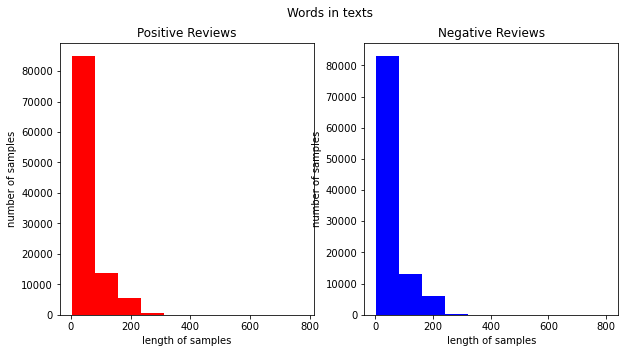

In [12]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
text_len = df[df['label']==1]['tag_list'].map(lambda x: len(x))
ax1.hist(text_len, color='red')
ax1.set_title('Positive Reviews')
ax1.set_xlabel('length of samples')
ax1.set_ylabel('number of samples')
print('긍정 리뷰의 평균 길이 :', np.mean(text_len))

text_len = df[df['label']==0]['tag_list'].map(lambda x: len(x))
ax2.hist(text_len, color='blue')
ax2.set_title('Negative Reviews')
fig.suptitle('Words in texts')
ax2.set_xlabel('length of samples')
ax2.set_ylabel('number of samples')
print('부정 리뷰의 평균 길이 :', np.mean(text_len))
plt.show()

### 긍부정 리뷰 나눠주기

In [ ]:
# 단어의 길이 분포 확인
#negative_words = np.hstack(df[df.label == 0]['tagging'].values)
#positive_words = np.hstack(df[df.label == 1]['tagging'].values)

### 객체 빈도수 확인하기

In [ ]:
#word_list = " ".join(df['sentence'].tolist())

In [ ]:
#words = okt.pos(word_list,stem=True)

In [ ]:
#len(words)

In [ ]:
#print(words[:10])

In [ ]:
#개수확인하기
#from collections import Counter
#frequent = Counter(words).most_common()

In [ ]:
#빈도분석
#frequent

In [ ]:
#텍스트 정제 (형태소 분석)
#for i, document in enumerate(sen):
    #okt = konlpy.tag.Okt()
    #clean_words = []
    #for word in okt.pos(document, stem=True): #어간 추출
        #if word[1] in ['Noun', 'Verb', 'Adjective']: #명사, 동사, 형용사
            #clean_words.append(word[0])
    #print(clean_words) #['스토리', '진짜', '노잼']
    #document = ' '.join(clean_words)
    #print(document) #스토리 진짜 노잼
    #sen[i] = document
#print(sen) 

In [ ]:
#sen

In [ ]:
#frequent = Counter(sen).most_common()

In [ ]:
#frequent

### 정수 인코딩

In [13]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [14]:
print(tokenizer.word_index)

{"'영화'": 1, "'하다'": 2, "'보다'": 3, "'없다'": 4, "'좋다'": 5, "'있다'": 6, "'정말'": 7, "'재밌다'": 8, "'되다'": 9, "'이다'": 10, "'같다'": 11, "'진짜'": 12, "'아니다'": 13, "'않다'": 14, "'이'": 15, "'점'": 16, "'연기'": 17, "'것'": 18, "'만들다'": 19, "'나오다'": 20, "'평점'": 21, "'최고'": 22, "'스토리'": 23, "'생각'": 24, "'왜'": 25, "'사람'": 26, "'감동'": 27, "'드라마'": 28, "'보고'": 29, "'배우'": 30, "'이렇다'": 31, "'말'": 32, "'더'": 33, "'아깝다'": 34, "'때'": 35, "'거'": 36, "'감독'": 37, "'재미있다'": 38, "'내'": 39, "'자다'": 40, "'시간'": 41, "'재미'": 42, "'내용'": 43, "'그냥'": 44, "'그'": 45, "'뭐'": 46, "'주다'": 47, "'좀'": 48, "'재미없다'": 49, "'지루하다'": 50, "'수'": 51, "'쓰레기'": 52, "'들다'": 53, "'모르다'": 54, "'가다'": 55, "'싶다'": 56, "'그렇다'": 57, "'볼'": 58, "'사랑'": 59, "'작품'": 60, "'나'": 61, "'알다'": 62, "'하나'": 63, "'다시'": 64, "'마지막'": 65, "'정도'": 66, "'오다'": 67, "'이건'": 68, "'많다'": 69, "'장면'": 70, "'액션'": 71, "'완전'": 72, "'주인공'": 73, "'처음'": 74, "'걸'": 75, "'나다'": 76, "'최악'": 77, "'차다'": 78, "'연출'": 79, "'안되다'": 80, "'안'": 81, "'이야기'": 82, "'지금'": 83, "'느낌'": 

In [15]:
# 단어가 44253개 존재함. 
# 각 정수는 전체 훈련 데이터에서 등장 빈도수가 높은 순서대로 부여됨. 
# 높은 정수(큰 숫자)가 부여된 단어들은 등장 빈도수가 매우 낮다는 것을 의미함. 

In [16]:
threshold = 2
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt) * 100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq) * 100)

단어 집합(vocabulary)의 크기 : 44253
등장 빈도가 1번 이하인 희귀 단어의 수: 18909
단어 집합에서 희귀 단어의 비율: 42.72930648769575
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 1.2199323356584886


In [17]:
# 등장 빈도가 threshold 값인 2회 미만. 즉, 1회 이하인 단어들은 단어 집합에서 약 40%을 차지함.
# 실제로 훈련 데이터에서 등장 빈도로 차지하는 비중은 1% 정도 되는데, 이를 삭제하는 것이 좋을까,, 

In [18]:
# 전체 단어 개수 중 빈도수 1 이하인 단어는 제거.
# 0번 패딩 토큰을 고려하여 + 1
vocab_size = total_cnt - rare_cnt + 1
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 25345


In [19]:
tokenizer = Tokenizer(vocab_size) 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [20]:
print(X_train[:3])

[[], [5921, 1099, 773, 2974, 612, 250, 3, 33, 8, 853, 503, 64, 3, 95, 8, 1, 3, 54, 264, 147, 266, 47, 528, 5396, 16561, 137, 773, 427, 3317, 16562, 1404, 10024, 2643, 4461], [206]]


In [21]:
# 위에서 처리 했음 
# y_train = np.array(train_data['label'])
# y_test = np.array(test_data['label'])

In [22]:
Y_train

array([1, 1, 1, ..., 1, 0, 1], dtype=int64)

In [23]:
X_train

[[],
 [5921,
  1099,
  773,
  2974,
  612,
  250,
  3,
  33,
  8,
  853,
  503,
  64,
  3,
  95,
  8,
  1,
  3,
  54,
  264,
  147,
  266,
  47,
  528,
  5396,
  16561,
  137,
  773,
  427,
  3317,
  16562,
  1404,
  10024,
  2643,
  4461],
 [206],
 [2307,
  1090,
  6592,
  8758,
  1262,
  45,
  8758,
  98,
  2,
  2,
  101,
  158,
  5397,
  8758,
  3317,
  233,
  6122,
  1412,
  1968,
  824,
  2438,
  1934,
  1412,
  1968,
  2167,
  642,
  85,
  10819,
  546,
  2,
  18,
  101,
  3374,
  1346,
  302,
  185,
  10820],
 [345],
 [621, 12, 5246, 33, 211, 7849, 25, 144, 194, 211, 33, 115, 331],
 [68, 419],
 [69, 18, 99, 106, 1],
 [31, 1, 16563, 865],
 [999, 132, 8, 26, 72, 5087, 853, 212, 518, 2378, 999, 4115, 8, 280],
 [1189, 1387, 173, 4560, 2, 2308, 3061, 2, 185, 2309, 691],
 [32, 351, 27, 1],
 [5, 145, 114],
 [6355, 203],
 [15, 42, 4, 417, 120, 38],
 [5922, 16564, 35, 276, 424, 53, 17, 7, 2],
 [148, 331],
 [354, 817, 80],
 [1510, 37, 560, 3, 308, 11788, 161, 148],
 [1442, 19741, 434, 496

### 빈 샘플(empty samples) 제거

In [24]:
# 샘플들의 길이를 확인해서 길이가 0인 샘플들의 인덱스 추출
drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]
len(drop_train)

585

In [25]:
# 빈 샘플들을 제거
X_train = np.delete(X_train, drop_train, axis=0)
Y_train = np.delete(Y_train, drop_train, axis=0)
print(len(X_train))
print(len(Y_train))

165479
165479


C:\Users\user\Desktop\.ipynb_checkpoints\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


리뷰의 최대 길이 : 133
리뷰의 평균 길이 : 9.252503338792234


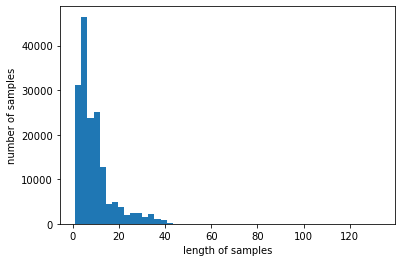

In [26]:
print('리뷰의 최대 길이 :',max(len(review) for review in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(review) for review in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [27]:
# 리뷰의 최대 길이는 133, 평균 길이는 약 9.25입니다. 그래프로 봤을 때, 전체적으로는 40 이하의 길이를 가지는 것으로 보입니다.

In [28]:
def below_threshold_len(max_len, nested_list):
    count = 0
    for sentence in nested_list:
        if(len(sentence) <= max_len):
            count = count + 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))

In [29]:
# 최대 길이가 133이므로 만약 30으로 패딩할 경우, 몇 개의 샘플들을 온전히 보전할 수 있는지 확인
max_len = 30
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 30 이하인 샘플의 비율: 96.23879767221219


### Padding

In [30]:
X_train = pad_sequences(X_train, maxlen = max_len)
X_test = pad_sequences(X_test, maxlen = max_len)

In [31]:
X_train

array([[  612,   250,     3, ..., 10024,  2643,  4461],
       [    0,     0,     0, ...,     0,     0,   206],
       [   98,     2,     2, ...,   302,   185, 10820],
       ...,
       [    0,     0,     0, ...,  2223,    91,     5],
       [    0,     0,     0, ...,   275,    33,    38],
       [    0,     0,     0, ...,     1,  1807,   225]])

In [32]:
X_test

array([[   0,    0,    0, ...,   26, 1064,   11],
       [   0,    0,    0, ...,   33,    8,   99],
       [   0,    0,    0, ..., 2775,  453,   10],
       ...,
       [   0,    0,    0, ...,   18,  231,  361],
       [   0,    0,    0, ...,    0,   50,    3],
       [8606, 2095, 1161, ...,  357,   14,   18]])

In [33]:
Y_train

array([1, 1, 1, ..., 1, 0, 1], dtype=int64)

In [34]:
Y_test

array([1, 1, 1, ..., 1, 0, 1], dtype=int64)

In [35]:
print(f'X_train: {X_train.shape}, X_test: {X_test.shape}, Y_train: {Y_train.shape}, Y_test: {Y_test.shape}')

X_train: (165479, 30), X_test: (41516, 30), Y_train: (165479,), Y_test: (41516,)


### Create a Model

In [36]:
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Embedding, Dense, GlobalMaxPool1D, MaxPooling2D, Flatten, Conv2D, MaxPooling1D, Conv1D
from tensorflow.keras.layers import Input, Activation, Dense, Permute, Dropout # Permute : 주어진 패턴에 따라서 입력 차수 변경
from tensorflow.keras.layers import add, dot, concatenate
from tensorflow.keras.layers import LSTM, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

In [153]:
# 논문을 보니, CNN-LSTM 모델을 같이 사용하면 정확도가 90%까지 올라간다고 하던데,,
# 내가 할 수 있을까,,,

In [202]:
# CNN를 사용한 모델 (model1) 정의
embedding_dim = 100
hidden_units = 128

model1 = Sequential()
model1.add(Embedding(vocab_size, embedding_dim, input_length = max_len))
model1.add(Conv1D(256, kernel_size = 3, padding = 'SAME', activation = 'relu', input_shape = (10, 4)))
model1.add(Conv1D(128, kernel_size = 3, padding = 'SAME', activation = 'relu'))
model1.add(Conv1D(64, kernel_size = 3, padding = 'SAME', activation = 'relu'))
model1.add(MaxPooling1D(pool_size = 2))
model1.add(Dropout(0.25))
model1.add(Flatten())
model1.add(Dropout(0.3))
model1.add(Dense(100, activation = 'relu'))
model1.add(Dense(32, activation = 'relu'))
model1.add(Dense(1, activation = 'sigmoid'))
    
es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 4)
mc = ModelCheckpoint('review_best_model_10.h5', monitor = 'val_acc', mode = 'max', verbose = 1, save_best_only = True)

model1.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy', metrics = ['acc']) # adam
model1.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_16 (Embedding)    (None, 30, 100)           2534500   
                                                                 
 conv1d_6 (Conv1D)           (None, 30, 256)           77056     
                                                                 
 conv1d_7 (Conv1D)           (None, 30, 128)           98432     
                                                                 
 conv1d_8 (Conv1D)           (None, 30, 64)            24640     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 15, 64)           0         
 1D)                                                             
                                                                 
 dropout_9 (Dropout)         (None, 15, 64)            0         
                                                     

In [37]:
# CNN를 사용한 모델 (model3) 정의
embedding_dim = 100
hidden_units = 128

model3 = Sequential()
model3.add(Embedding(vocab_size, embedding_dim, input_length = max_len))
model3.add(Conv1D(256, kernel_size = 3, padding = 'SAME', activation = 'relu', input_shape = (10, 4)))
model3.add(Conv1D(128, kernel_size = 3, padding = 'SAME', activation = 'relu'))
model3.add(Conv1D(128, kernel_size = 3, padding = 'SAME', activation = 'relu'))
model3.add(Conv1D(64, kernel_size = 3, padding = 'SAME', activation = 'relu'))
model3.add(Conv1D(32, kernel_size = 3, padding = 'SAME', activation = 'relu'))
model3.add(MaxPooling1D(pool_size = 2))
model3.add(Dropout(0.25))
model3.add(Flatten())
model3.add(Dropout(0.3))
model3.add(Dense(100, activation = 'relu'))
model3.add(Dense(64, activation = 'relu'))
model3.add(Dense(32, activation = 'relu'))
model3.add(Dense(1, activation = 'sigmoid'))
    
es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 4)
mc = ModelCheckpoint('review_best_model_11.h5', monitor = 'val_acc', mode = 'max', verbose = 1, save_best_only = True)

model3.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy', metrics = ['acc']) # adam
model3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 30, 100)           2534500   
                                                                 
 conv1d (Conv1D)             (None, 30, 256)           77056     
                                                                 
 conv1d_1 (Conv1D)           (None, 30, 128)           98432     
                                                                 
 conv1d_2 (Conv1D)           (None, 30, 128)           49280     
                                                                 
 conv1d_3 (Conv1D)           (None, 30, 64)            24640     
                                                                 
 conv1d_4 (Conv1D)           (None, 30, 32)            6176      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 15, 32)           0

In [190]:
# LSTM를 사용한 모델 (model2) 정의
embedding_dim = 100
hidden_units = 128

model2 = Sequential()
model2.add(Embedding(vocab_size, embedding_dim))
model2.add(LSTM(hidden_units))
model2.add(Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 4)
mc = ModelCheckpoint('review_best_model_8.h5', monitor = 'val_acc', mode = 'max', verbose = 1, save_best_only = True)

model2.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy', metrics = ['acc']) # adam
model2.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, None, 100)         2534500   
                                                                 
 lstm_10 (LSTM)              (None, 128)               117248    
                                                                 
 dense_9 (Dense)             (None, 1)                 129       
                                                                 
Total params: 2,651,877
Trainable params: 2,651,877
Non-trainable params: 0
_________________________________________________________________


In [40]:
# CNN를 사용한 모델 (model4) 정의
embedding_dim = 100
hidden_units = 128

model4 = Sequential()
model4.add(Embedding(vocab_size, embedding_dim, input_length = max_len))
model4.add(Conv1D(256, kernel_size = 5, padding = 'SAME', activation = 'relu', input_shape = (10, 4)))
model4.add(Conv1D(128, kernel_size = 5, padding = 'SAME', activation = 'relu'))
model4.add(Conv1D(64, kernel_size = 5, padding = 'SAME', activation = 'relu'))
model4.add(MaxPooling1D(pool_size = 2))
model4.add(Dropout(0.3))
model4.add(Flatten())
model4.add(Dropout(0.3))
model4.add(Dense(100, activation = 'relu'))
model4.add(Dense(32, activation = 'relu'))
model4.add(Dense(1, activation = 'sigmoid'))
    
es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 4)
mc = ModelCheckpoint('review_best_model_12.h5', monitor = 'val_acc', mode = 'max', verbose = 1, save_best_only = True)

model4.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy', metrics = ['acc']) # adam
model4.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 30, 100)           2534500   
                                                                 
 conv1d_5 (Conv1D)           (None, 30, 256)           128256    
                                                                 
 conv1d_6 (Conv1D)           (None, 30, 128)           163968    
                                                                 
 conv1d_7 (Conv1D)           (None, 30, 64)            41024     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 15, 64)           0         
 1D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 15, 64)            0         
                                                      

In [50]:
# CNN-LSTM를 사용한 모델 (model7) 정의
embedding_dim = 100
hidden_units = 128

model7 = Sequential()
model7.add(Embedding(vocab_size, embedding_dim))
model7.add(Conv1D(128, kernel_size = 5, padding = 'SAME', activation = 'relu', input_shape = (10, 4)))
model7.add(MaxPooling1D(pool_size = 4))
model7.add(Conv1D(128, kernel_size = 5, padding = 'SAME', activation = 'relu'))
model7.add(Dropout(0.25))
model7.add(LSTM(hidden_units))
model7.add(Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 4)
mc = ModelCheckpoint('review_best_model_15.h5', monitor = 'val_acc', mode = 'max', verbose = 1, save_best_only = True)

model7.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy', metrics = ['acc']) # adam
model7.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, None, 100)         2534500   
                                                                 
 conv1d_12 (Conv1D)          (None, None, 128)         64128     
                                                                 
 max_pooling1d_4 (MaxPooling  (None, None, 128)        0         
 1D)                                                             
                                                                 
 conv1d_13 (Conv1D)          (None, None, 128)         82048     
                                                                 
 dropout_6 (Dropout)         (None, None, 128)         0         
                                                                 
 lstm_2 (LSTM)               (None, 128)               131584    
                                                      

In [205]:
r1 = model1.fit(X_train, Y_train, epochs = 30, callbacks = [es, mc], batch_size = 64, validation_data = (X_test, Y_test))

Epoch 1/30
2584/2586 [============================>.] - ETA: 0s - loss: 0.3966 - acc: 0.8191
Epoch 1: val_acc improved from -inf to 0.84382, saving model to review_best_model_10.h5
2586/2586 [==============================] - 77s 30ms/step - loss: 0.3966 - acc: 0.8191 - val_loss: 0.3688 - val_acc: 0.8438
Epoch 2/30
2584/2586 [============================>.] - ETA: 0s - loss: 0.3422 - acc: 0.8559
Epoch 2: val_acc did not improve from 0.84382
2586/2586 [==============================] - 75s 29ms/step - loss: 0.3422 - acc: 0.8558 - val_loss: 0.3849 - val_acc: 0.8400
Epoch 3/30
2585/2586 [============================>.] - ETA: 0s - loss: 0.3282 - acc: 0.8654
Epoch 3: val_acc improved from 0.84382 to 0.85189, saving model to review_best_model_10.h5
2586/2586 [==============================] - 76s 29ms/step - loss: 0.3282 - acc: 0.8654 - val_loss: 0.3470 - val_acc: 0.8519
Epoch 4/30
2584/2586 [============================>.] - ETA: 0s - loss: 0.3242 - acc: 0.8718
Epoch 4: val_acc did not imp

In [191]:
r2 = model2.fit(X_train, Y_train, epochs = 15, callbacks = [es, mc], batch_size = 64, validation_data = (X_test, Y_test))

Epoch 1/15
2586/2586 [==============================] - ETA: 0s - loss: 0.3912 - acc: 0.8223
Epoch 1: val_acc improved from -inf to 0.84009, saving model to review_best_model_8.h5
2586/2586 [==============================] - 335s 127ms/step - loss: 0.3912 - acc: 0.8223 - val_loss: 0.3592 - val_acc: 0.8401
Epoch 2/15
2586/2586 [==============================] - ETA: 0s - loss: 0.3367 - acc: 0.8536
Epoch 2: val_acc improved from 0.84009 to 0.84632, saving model to review_best_model_8.h5
2586/2586 [==============================] - 338s 131ms/step - loss: 0.3367 - acc: 0.8536 - val_loss: 0.3496 - val_acc: 0.8463
Epoch 3/15
2586/2586 [==============================] - ETA: 0s - loss: 0.3142 - acc: 0.8680
Epoch 3: val_acc improved from 0.84632 to 0.84984, saving model to review_best_model_8.h5
2586/2586 [==============================] - 350s 135ms/step - loss: 0.3142 - acc: 0.8680 - val_loss: 0.3439 - val_acc: 0.8498
Epoch 4/15
2586/2586 [==============================] - ETA: 0s - loss: 0

In [38]:
r3 = model3.fit(X_train, Y_train, epochs = 15, callbacks = [es, mc], batch_size = 64, validation_data = (X_test, Y_test))

Epoch 1/15
2586/2586 [==============================] - ETA: 0s - loss: 0.3997 - acc: 0.8184
Epoch 1: val_acc improved from -inf to 0.84572, saving model to review_best_model_11.h5
2586/2586 [==============================] - 224s 85ms/step - loss: 0.3997 - acc: 0.8184 - val_loss: 0.3579 - val_acc: 0.8457
Epoch 2/15
2586/2586 [==============================] - ETA: 0s - loss: 0.3412 - acc: 0.8567
Epoch 2: val_acc did not improve from 0.84572
2586/2586 [==============================] - 220s 85ms/step - loss: 0.3412 - acc: 0.8567 - val_loss: 0.3623 - val_acc: 0.8416
Epoch 3/15
2586/2586 [==============================] - ETA: 0s - loss: 0.3269 - acc: 0.8673
Epoch 3: val_acc improved from 0.84572 to 0.85170, saving model to review_best_model_11.h5
2586/2586 [==============================] - 220s 85ms/step - loss: 0.3269 - acc: 0.8673 - val_loss: 0.3538 - val_acc: 0.8517
Epoch 4/15
2584/2586 [============================>.] - ETA: 0s - loss: 0.3161 - acc: 0.8736
Epoch 4: val_acc did not 

In [41]:
r4 = model4.fit(X_train, Y_train, epochs = 15, callbacks = [es, mc], batch_size = 64, validation_data = (X_test, Y_test))

Epoch 1/15
2586/2586 [==============================] - ETA: 0s - loss: 0.3960 - acc: 0.8214
Epoch 1: val_acc improved from -inf to 0.83946, saving model to review_best_model_12.h5
2586/2586 [==============================] - 92s 35ms/step - loss: 0.3960 - acc: 0.8214 - val_loss: 0.3636 - val_acc: 0.8395
Epoch 2/15
2586/2586 [==============================] - ETA: 0s - loss: 0.3457 - acc: 0.8570
Epoch 2: val_acc improved from 0.83946 to 0.85095, saving model to review_best_model_12.h5
2586/2586 [==============================] - 91s 35ms/step - loss: 0.3457 - acc: 0.8570 - val_loss: 0.3511 - val_acc: 0.8509
Epoch 3/15
2586/2586 [==============================] - ETA: 0s - loss: 0.3346 - acc: 0.8666
Epoch 3: val_acc improved from 0.85095 to 0.85145, saving model to review_best_model_12.h5
2586/2586 [==============================] - 92s 35ms/step - loss: 0.3346 - acc: 0.8666 - val_loss: 0.3789 - val_acc: 0.8515
Epoch 4/15
2586/2586 [==============================] - ETA: 0s - loss: 0.33

In [44]:
r5 = model5.fit(X_train, Y_train, epochs = 15, callbacks = [es, mc], batch_size = 64, validation_data = (X_test, Y_test))

Epoch 1/15
2584/2586 [============================>.] - ETA: 0s - loss: 0.3889 - acc: 0.8226
Epoch 1: val_acc improved from -inf to 0.84230, saving model to review_best_model_13.h5
2586/2586 [==============================] - 76s 29ms/step - loss: 0.3889 - acc: 0.8226 - val_loss: 0.3588 - val_acc: 0.8423
Epoch 2/15
2585/2586 [============================>.] - ETA: 0s - loss: 0.3277 - acc: 0.8605
Epoch 2: val_acc improved from 0.84230 to 0.84938, saving model to review_best_model_13.h5
2586/2586 [==============================] - 82s 32ms/step - loss: 0.3276 - acc: 0.8605 - val_loss: 0.3474 - val_acc: 0.8494
Epoch 3/15
2584/2586 [============================>.] - ETA: 0s - loss: 0.2973 - acc: 0.8772
Epoch 3: val_acc improved from 0.84938 to 0.84946, saving model to review_best_model_13.h5
2586/2586 [==============================] - 69s 27ms/step - loss: 0.2973 - acc: 0.8772 - val_loss: 0.3561 - val_acc: 0.8495
Epoch 4/15
2585/2586 [============================>.] - ETA: 0s - loss: 0.26

In [51]:
r7 = model7.fit(X_train, Y_train, epochs = 20, callbacks = [es, mc], batch_size = 64, validation_data = (X_test, Y_test))

Epoch 1/20
2585/2586 [============================>.] - ETA: 0s - loss: 0.3892 - acc: 0.8228
Epoch 1: val_acc improved from -inf to 0.84259, saving model to review_best_model_15.h5
2586/2586 [==============================] - 78s 30ms/step - loss: 0.3892 - acc: 0.8228 - val_loss: 0.3597 - val_acc: 0.8426
Epoch 2/20
2584/2586 [============================>.] - ETA: 0s - loss: 0.3281 - acc: 0.8605
Epoch 2: val_acc improved from 0.84259 to 0.84644, saving model to review_best_model_15.h5
2586/2586 [==============================] - 80s 31ms/step - loss: 0.3281 - acc: 0.8605 - val_loss: 0.3466 - val_acc: 0.8464
Epoch 3/20
2585/2586 [============================>.] - ETA: 0s - loss: 0.2979 - acc: 0.8780
Epoch 3: val_acc improved from 0.84644 to 0.84893, saving model to review_best_model_15.h5
2586/2586 [==============================] - 90s 35ms/step - loss: 0.2978 - acc: 0.8780 - val_loss: 0.3485 - val_acc: 0.8489
Epoch 4/20
2586/2586 [==============================] - ETA: 0s - loss: 0.26

In [39]:
loaded_model = load_model('review_best_model_11.h5') # 정확도 85.16%
loaded_model.evaluate(X_test, Y_test)

1298/1298 [==============================] - 11s 8ms/step - loss: 0.3538 - acc: 0.8517


[0.35377955436706543, 0.851695716381073]

In [206]:
loaded_model = load_model('review_best_model_10.h5') # 정확도 85.51%
loaded_model.evaluate(X_test, Y_test)

1298/1298 [==============================] - 10s 8ms/step - loss: 0.3514 - acc: 0.8551


[0.35139697790145874, 0.855140209197998]

In [192]:
loaded_model = load_model('review_best_model_8.h5') # 정확도 85.29%
loaded_model.evaluate(X_test, Y_test)

1298/1298 [==============================] - 9s 6ms/step - loss: 0.3422 - acc: 0.8529


[0.34223541617393494, 0.8529482483863831]

In [42]:
loaded_model = load_model('review_best_model_12.h5') # 정확도 85.14%
loaded_model.evaluate(X_test, Y_test)

1298/1298 [==============================] - 11s 9ms/step - loss: 0.3789 - acc: 0.8515


[0.3788997232913971, 0.8514548540115356]

In [45]:
loaded_model = load_model('review_best_model_13.h5') # 정확도 84.95%
loaded_model.evaluate(X_test, Y_test)

1298/1298 [==============================] - 5s 4ms/step - loss: 0.3561 - acc: 0.8495


[0.3561263084411621, 0.8494556546211243]

In [52]:
loaded_model = load_model('review_best_model_15.h5') # 정확도 84.89%
loaded_model.evaluate(X_test, Y_test)

1298/1298 [==============================] - 5s 4ms/step - loss: 0.3485 - acc: 0.8489


[0.348463237285614, 0.8489257097244263]

### Evaluate the Model

In [207]:
import matplotlib.pyplot as plt
%matplotlib inline
print(r1.history.keys())

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


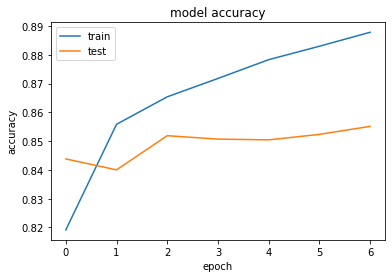

In [208]:
plt.plot(r1.history['acc'])
plt.plot(r1.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc = 'upper left')
plt.show()

In [183]:
# 과적합이 있네,,

### 예측

In [209]:
review1 = "솔직히 두 주인공의 감정이입이 안되다보니 아무느낌 없습니다"

In [210]:
# loaded_model.predict(review1) <- pad_sequences <- texts2sequnces <- stopwords <- review1 

In [213]:
from hanspell import spell_checker
def review_predict(review1):
    
    # 1. spell_checker
    spelled_sent = spell_checker.check(review1)
    hanspell_sent = spelled_sent.checked
    new_review = hanspell_sent
    
    # 2. 반복되는 문자 제거하기
    new_review = new_review.replace("ㅋ","") # ㅋㅋㅋ제거
    new_review = new_review.replace("ㅜ","") # ㅜㅜㅜ제거
    new_review = new_review.replace("ㅠ","") # ㅠㅠㅠ제거
    new_review = new_review.replace("ㅎ","") # ㅎㅎㅎ제거
    new_review = new_review.replace("ㅇ","") # ㅇㅇ제거
    new_review = new_review.replace("ㄷ","") # ㄷㄷ제거
    new_review = new_review.replace("ㄱ","") # ㄱㄱ제거
    new_review = new_review.replace("-","") # --제거
    new_review = new_review.replace("_","") # __제거
    new_review = new_review.replace("ㅡ","") # ㅡㅡ제거

    new_review = new_review.replace("ㅉ","")
    new_review = new_review.replace("ㅆㅈ","")
    new_review = new_review.replace("ㅏ","")
    new_review = new_review.replace("ㅡ","")
    
    # 3. 단어 변환해주기 - 줄임말 변경
    new_review = new_review.replace("ㄱㅊ","괜찮")
    new_review = new_review.replace("ㅈㄹ","지랄")
    new_review = new_review.replace("ㅈㅁ","정말")
    new_review = new_review.replace("ㅇㅈ","인정")
    new_review = new_review.replace("ㄹㅇ","정말")
    new_review = new_review.replace("ㅈㅅ","죄송")
    new_review = new_review.replace("좋ㅈ었습니다","좋았습니다")
    new_review = new_review.replace("ㅈㄴ","존나")

    # 4. 영어표현 변경
    new_review = new_review.replace("cg","씨지")
    new_review = new_review.replace("ost","오에스티")
    new_review = new_review.replace("sf","공상과학")
    new_review = new_review.replace("tv","텔레비전")
    new_review = new_review.replace("sns","소셜미디어")
    new_review = new_review.replace("good","좋다")
    new_review = new_review.replace("best","좋다")
    
    # 5. 한글과 공백을 제외하고 모두 제거 
    new_review = new_review.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")

    # 6. 토큰화
    new_review = okt.pos(new_review, stem = True) 
    new_review = [word for word, tag in new_review if tag in ['Noun','Adjective','Verb']] 
    
    # 7. Embedding 처리 (text -> sequences)
    new_review = tokenizer.texts_to_sequences([new_review])

    # 8. padding -> 길이 값을 맞추기 위해 
    padding_review = pad_sequences(new_review, maxlen = max_len)

    # 9. predcit 
    score = float(loaded_model.predict(padding_review))

    # 10. 결과 값 판단 
    if score > 0.5:
        print("{:.2f}% 확률로 긍정 리뷰".format(score * 100))
    else:
        print("{:.2f}% 확률로 부정 리뷰".format((1- score) * 100))

In [214]:
review_predict("솔직히 두 주인공의 감정이입이 안되다보니 아무느낌 없습니다")

98.26% 확률로 부정 리뷰


In [215]:
review_predict("정겨운 사람과 따뜻한 공간을 떠나온 지금도 가슴 속에 추억한다.")

94.33% 확률로 긍정 리뷰


In [216]:
review_predict("멸공이라는 단어를 악으로 만든 영화.전형적인 한국식 정치영화")

71.79% 확률로 부정 리뷰


In [217]:
#from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [218]:
#y_pred = review_predict("멸공이라는 단어를 악으로 만든 영화.전형적인 한국식 정치영화")
#y_pred

71.79% 확률로 부정 리뷰


In [220]:
# 찐, 예측
#print(classification_report(Y_test, y_pred))

ValueError: Expected array-like (array or non-string sequence), got None